In [1]:
%reload_ext autoreload
%autoreload 2

In [31]:
import utils as u
import importlib
importlib.reload(u)
import io
import requests
import os
import pandas as pd
from collections import Counter
from IPython.display import display, Markdown, Latex

In [3]:
r_orb = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': 'orbParams', # Mandatory, `orbParams` or `lightcurves`
  }
)
r_tra = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': 'lightcurves', # Mandatory, `orbParams` or `lightcurves`
  }
)

# Format output in a DataFrame
candid_reconstr_orbit = pd.read_json(io.BytesIO(r_orb.content))
candid_reconstr_traje = pd.read_json(io.BytesIO(r_tra.content))


## Results

In [7]:
Markdown("""|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Reconstructed orbit | {:,}      | {:,}             |""".format(len(candid_reconstr_orbit), len(candid_reconstr_orbit[candid_reconstr_orbit["d:rms_a"] != -1.0])))

|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Reconstructed orbit | 597      | 333             |

##### Number of detection

In [18]:
res_gb = candid_reconstr_traje.groupby("d:ssoCandId").agg(nb_det=("d:ra", len)).sort_values("nb_det")
Markdown("""
| |number of detection|
|-|-------------------|
|min| {:,}            |
|median|{:,}          |
|max|{:,}             |
""".format(res_gb.min().values[0], int(res_gb.median().values[0]), res_gb.max().values[0]))


| |number of detection|
|-|-------------------|
|min| 6            |
|median|6          |
|max|9             |


In [27]:
for k, v in Counter(res_gb["nb_det"]).items():
    print("nb det: {}, nb traj = {} ({:0.2f}%)".format(k, v, (v/len(res_gb))*100))

nb det: 6, nb traj = 506 (84.76%)
nb det: 7, nb traj = 79 (13.23%)
nb det: 8, nb traj = 11 (1.84%)
nb det: 9, nb traj = 1 (0.17%)


##### Observation window

In [48]:
res_gb_obs_tw = candid_reconstr_traje.sort_values("d:jd").groupby("d:ssoCandId").agg(obs_win=("d:jd", lambda x: list(x)[-1] - list(x)[0])).sort_values("obs_win")
Markdown("""
| |Observation window (days)|
|-|-------------------|
|min| {:0.3f}            |
|median|{:0.3f}          |
|max|{:0.3f}             |
""".format(res_gb_obs_tw.min().values[0], int(res_gb_obs_tw.median().values[0]), res_gb_obs_tw.max().values[0]))


| |Observation window (days)|
|-|-------------------|
|min| 0.981            |
|median|8.000          |
|max|33.908             |


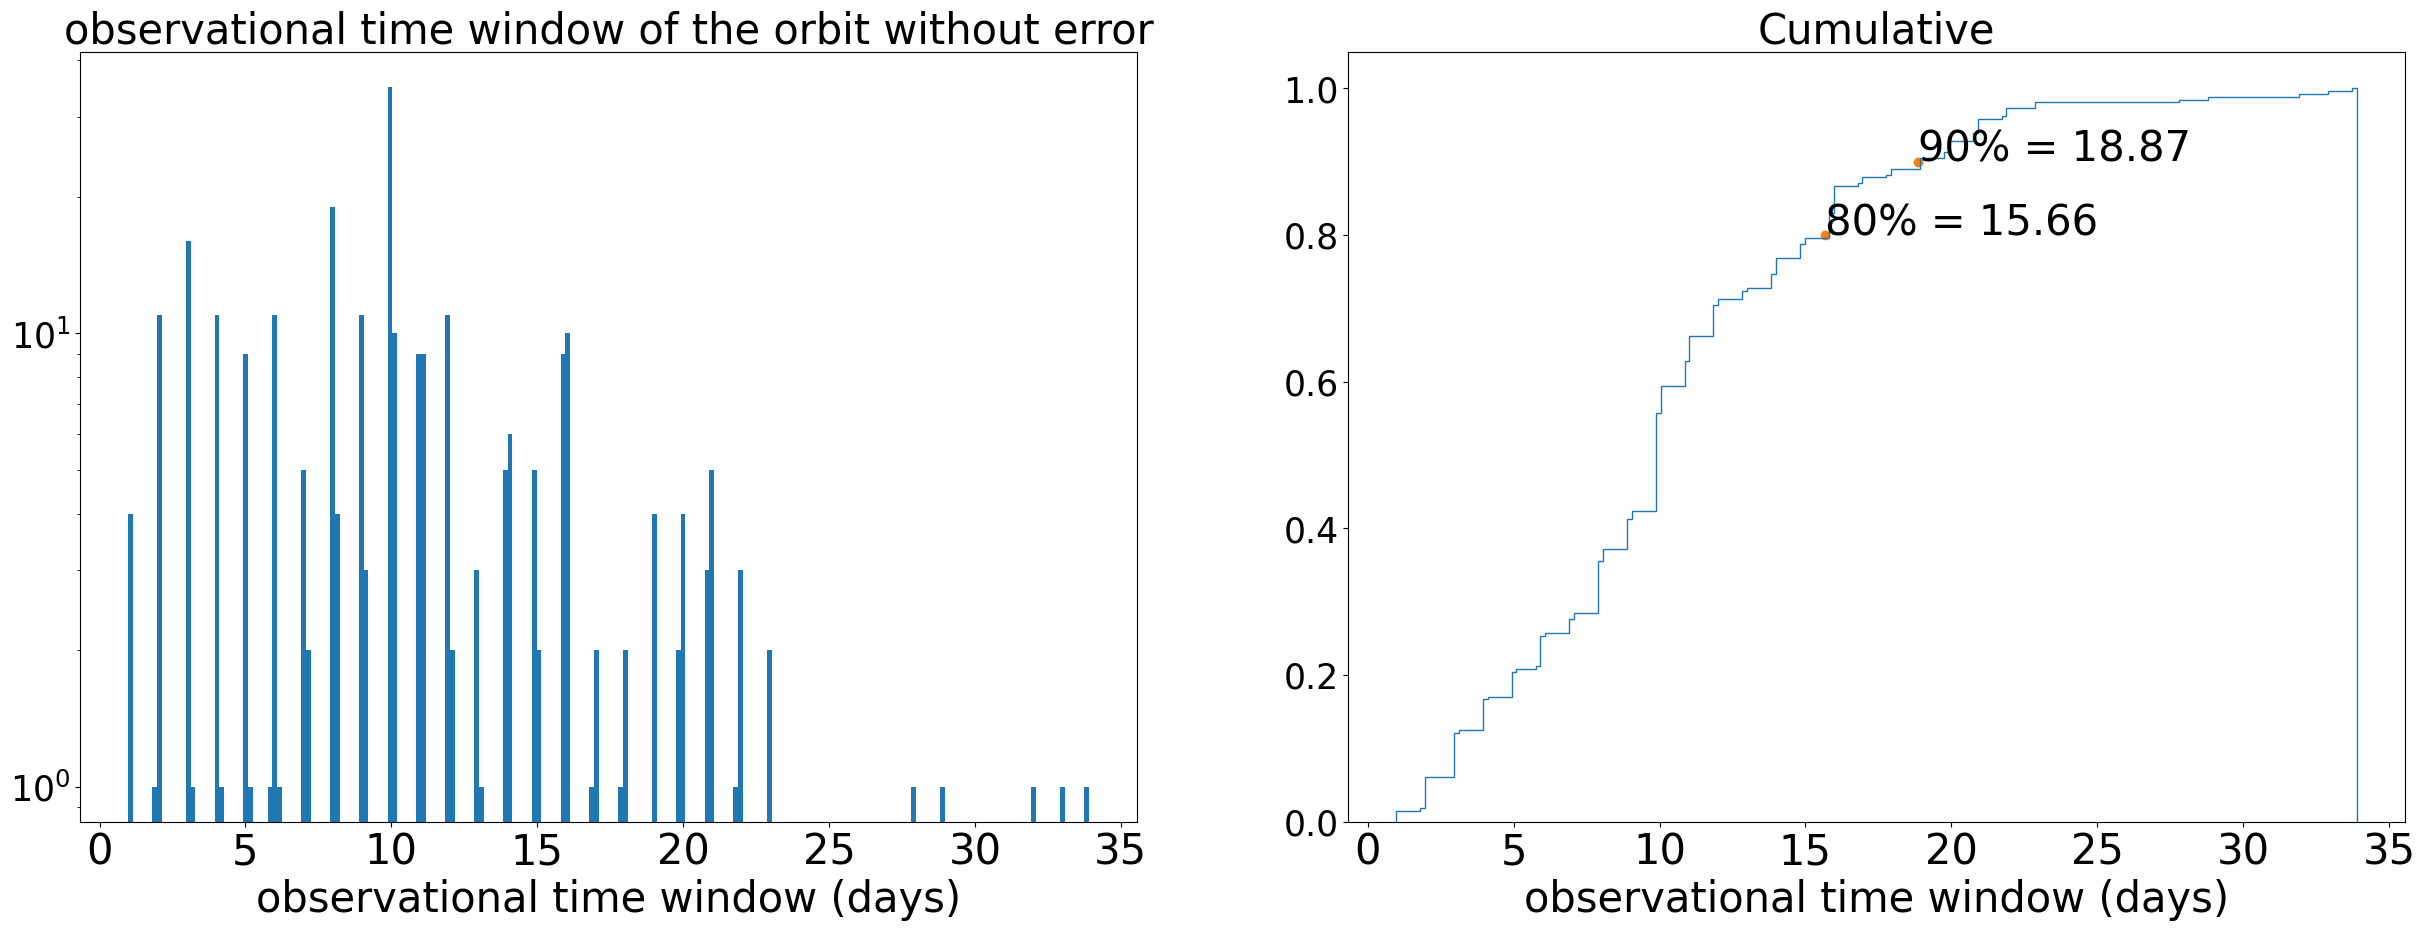

In [60]:
obstw_and_orb = candid_reconstr_orbit.merge(res_gb_obs_tw.reset_index(), on="d:ssoCandId")
u.plot_hist_and_cdf(
    obstw_and_orb[obstw_and_orb["d:rms_a"] == -1.0]["obs_win"], 
    None, "observational time window of the orbit without error", "observational time window (days)", "", 
    None, "Cumulative", "observational time window (days)", "")

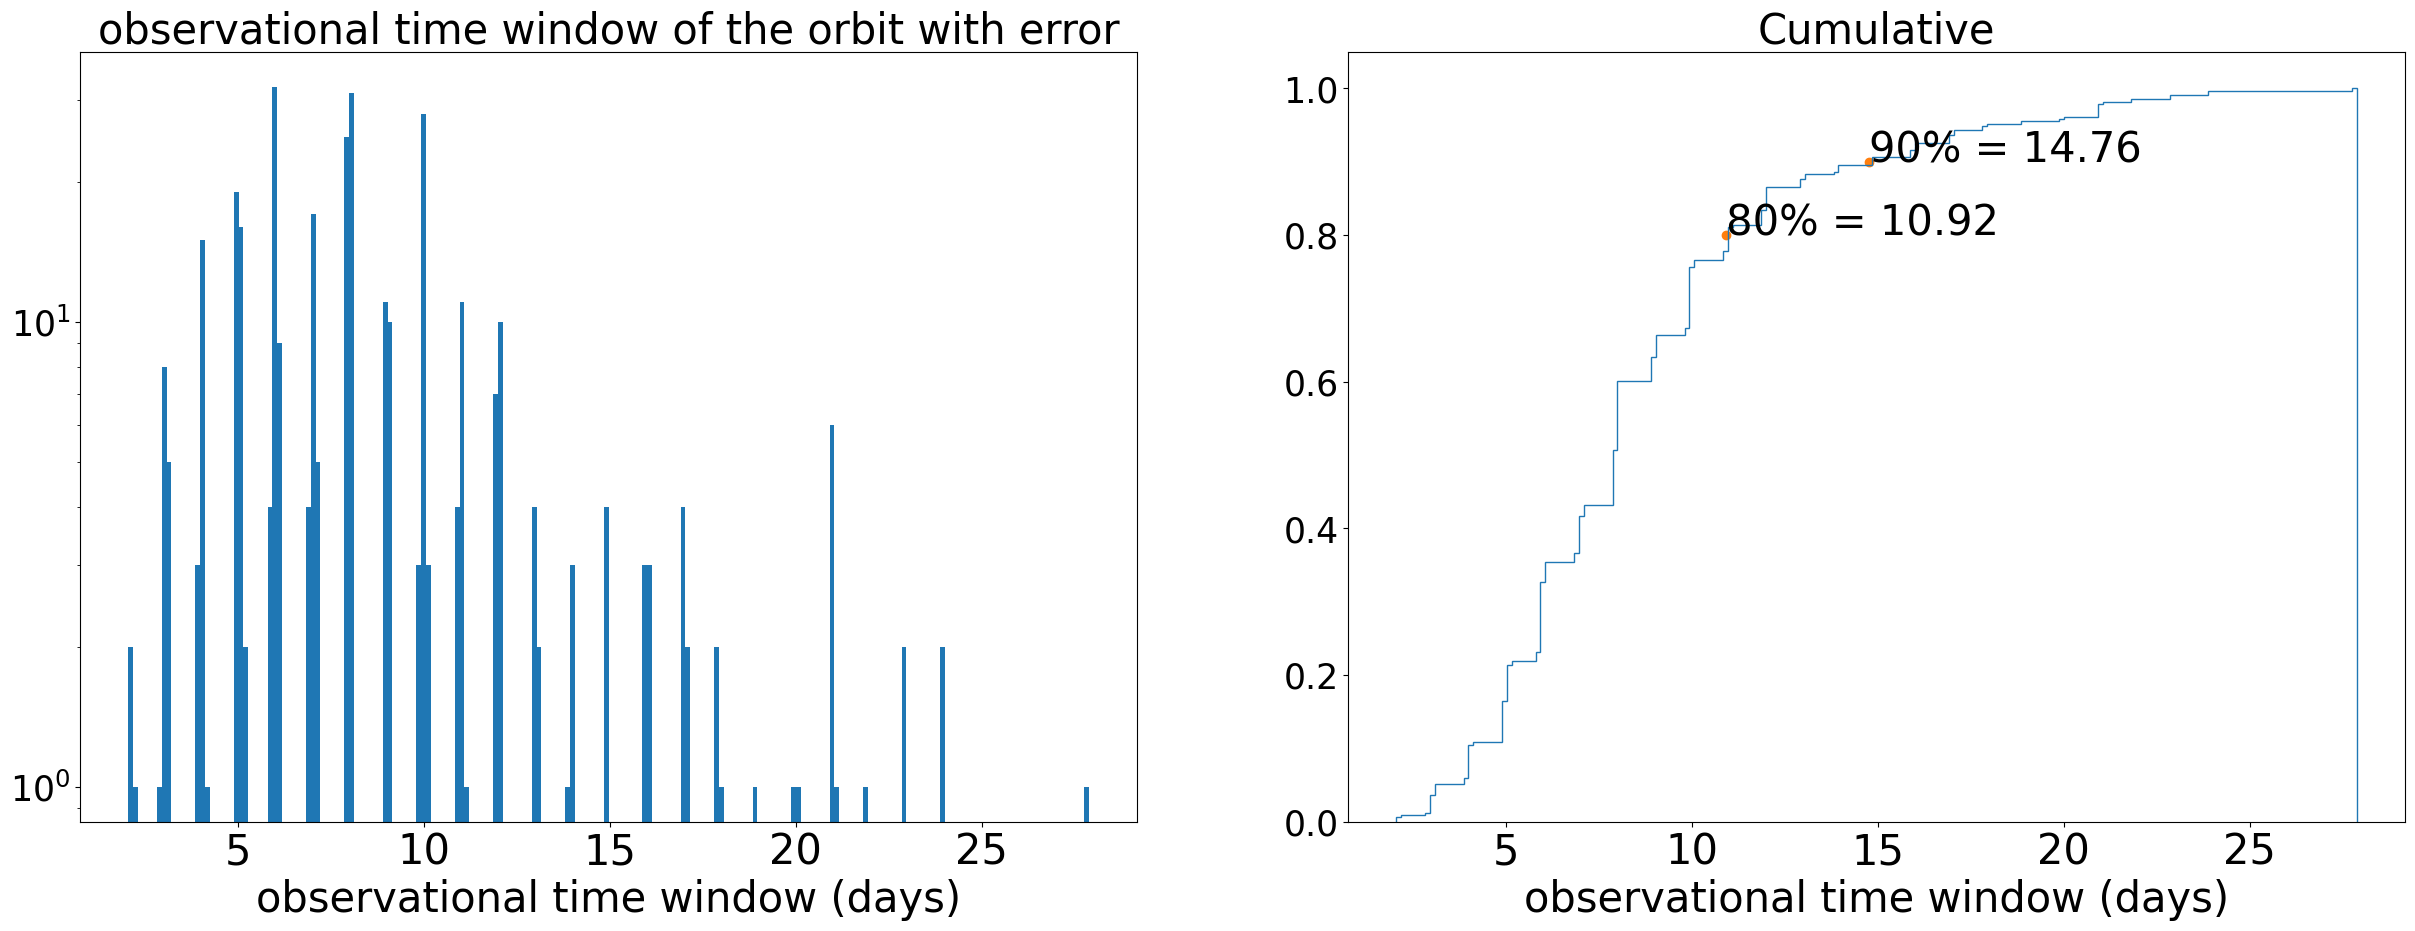

In [61]:
u.plot_hist_and_cdf(
    obstw_and_orb[obstw_and_orb["d:rms_a"] != -1.0]["obs_win"], 
    None, "observational time window of the orbit with error", "observational time window (days)", "", 
    None, "Cumulative", "observational time window (days)", "")

##### Association repartition

In [69]:
u.print_assoc_distrib(
    candid_reconstr_orbit.rename({d:d[2:] for d in candid_reconstr_orbit.columns}, axis=1), 
    candid_reconstr_traje.rename({d:d[2:] for d in candid_reconstr_traje.columns}, axis=1))
print()
print()
u.print_assoc_distrib(
    candid_reconstr_orbit.rename({d:d[2:] for d in candid_reconstr_orbit.columns}, axis=1), 
    candid_reconstr_traje.rename({d:d[2:] for d in candid_reconstr_traje.columns}, axis=1), False)

Association repartition (orbit with error)
	I : 213 (57.25806451612904)
	O : 39 (10.483870967741936)
	N : 120 (32.25806451612903)


Association repartition (orbit with error)
	I : 200 (70.17543859649122)
	N : 64 (22.45614035087719)
	O : 21 (7.368421052631578)


### Magnitude

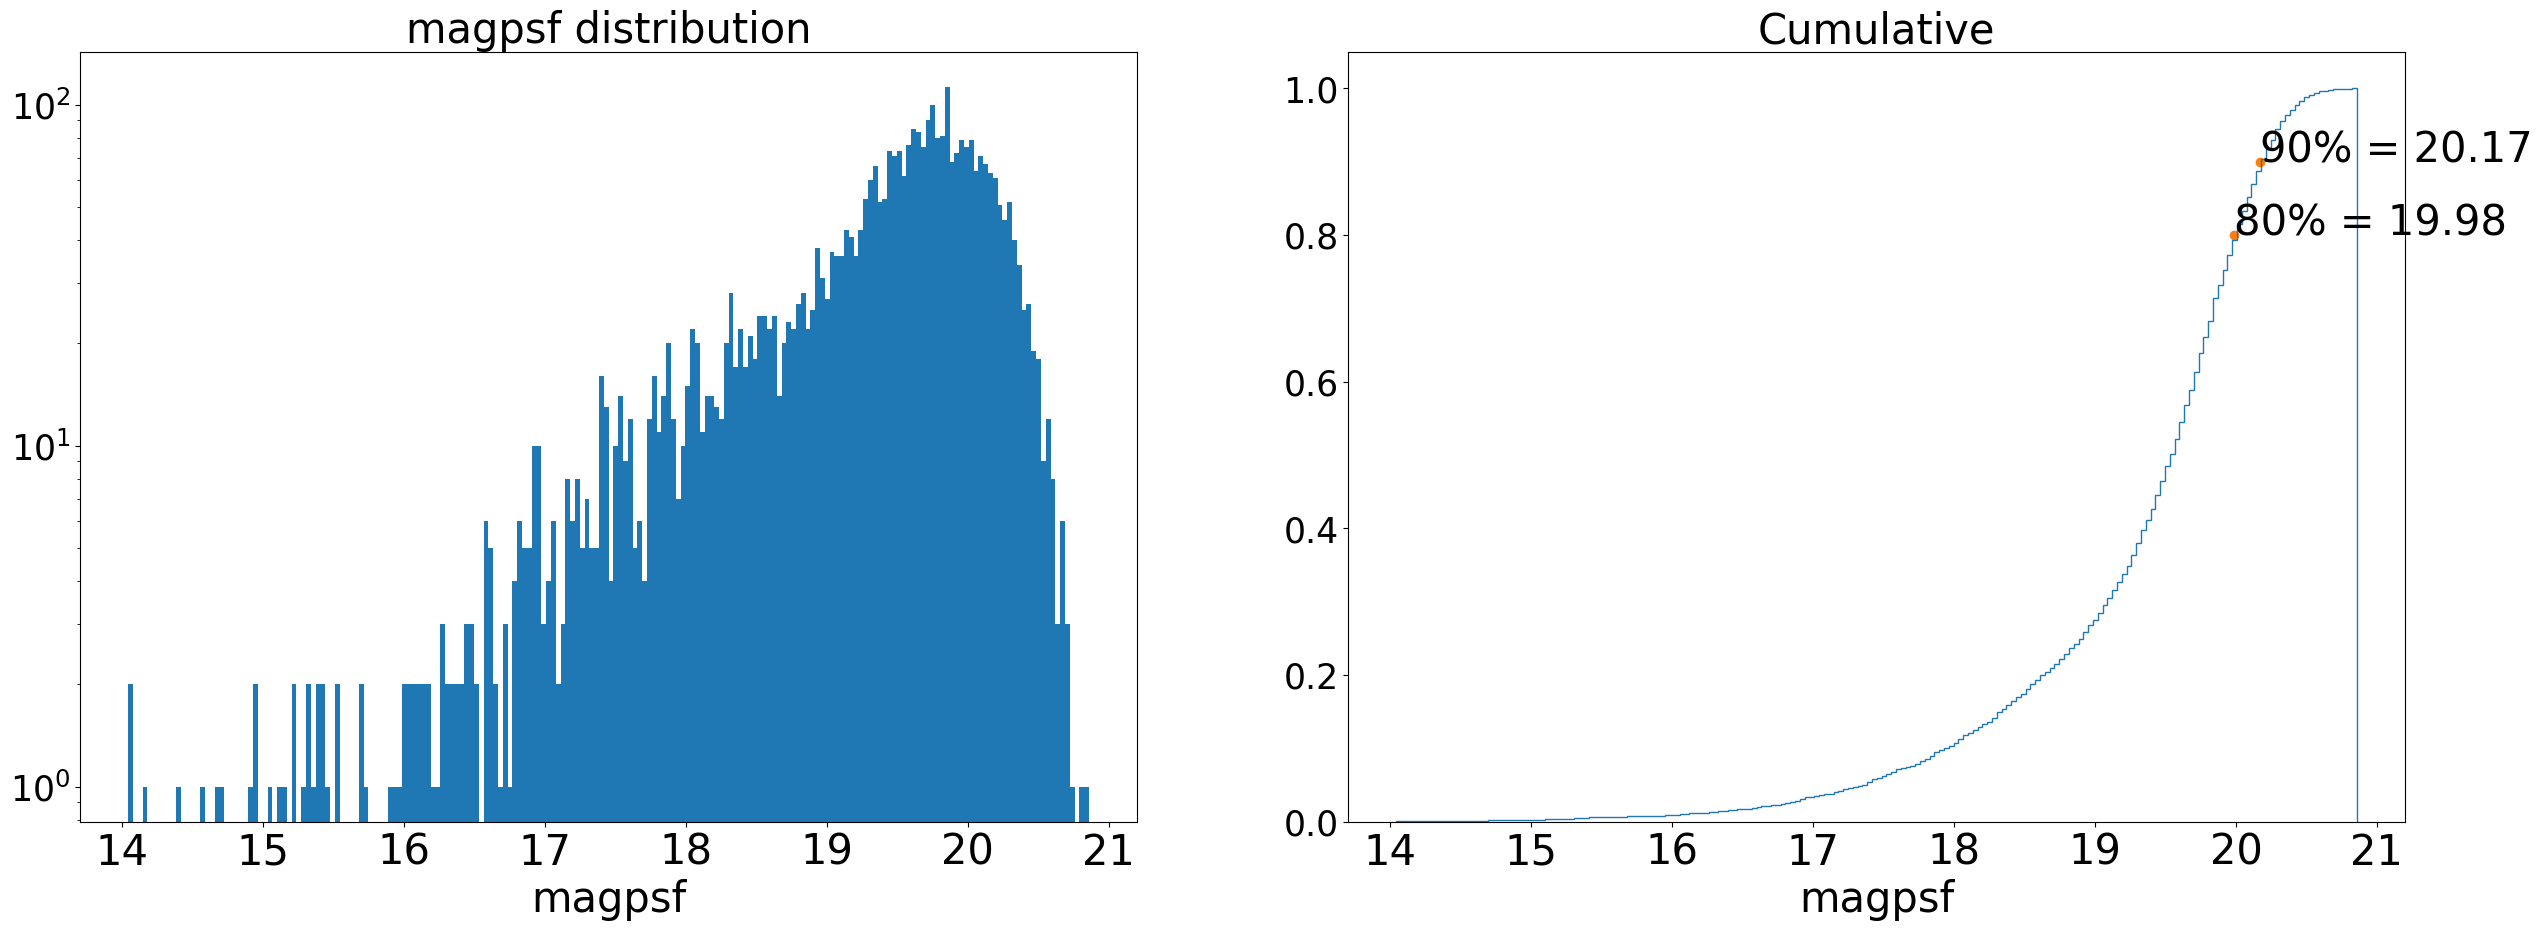

In [30]:
u.plot_hist_and_cdf(candid_reconstr_traje["d:magpsf"], None, "magpsf distribution", "magpsf", "", None, "Cumulative", "magpsf", "")

### RMS compared to confirmed reconstruction

In [35]:
from collections import Counter
path_tw_exp = "../fink_fat_experiments/time_window_experiments/15_2_2/all_assoc/confirmed_all_fink_fat/mpc"
reconstructed_orbit = pd.read_parquet(os.path.join(path_tw_exp, "orbital.parquet"))
reconstructed_trajectory = pd.read_parquet(os.path.join(path_tw_exp, "trajectory_orb.parquet"))

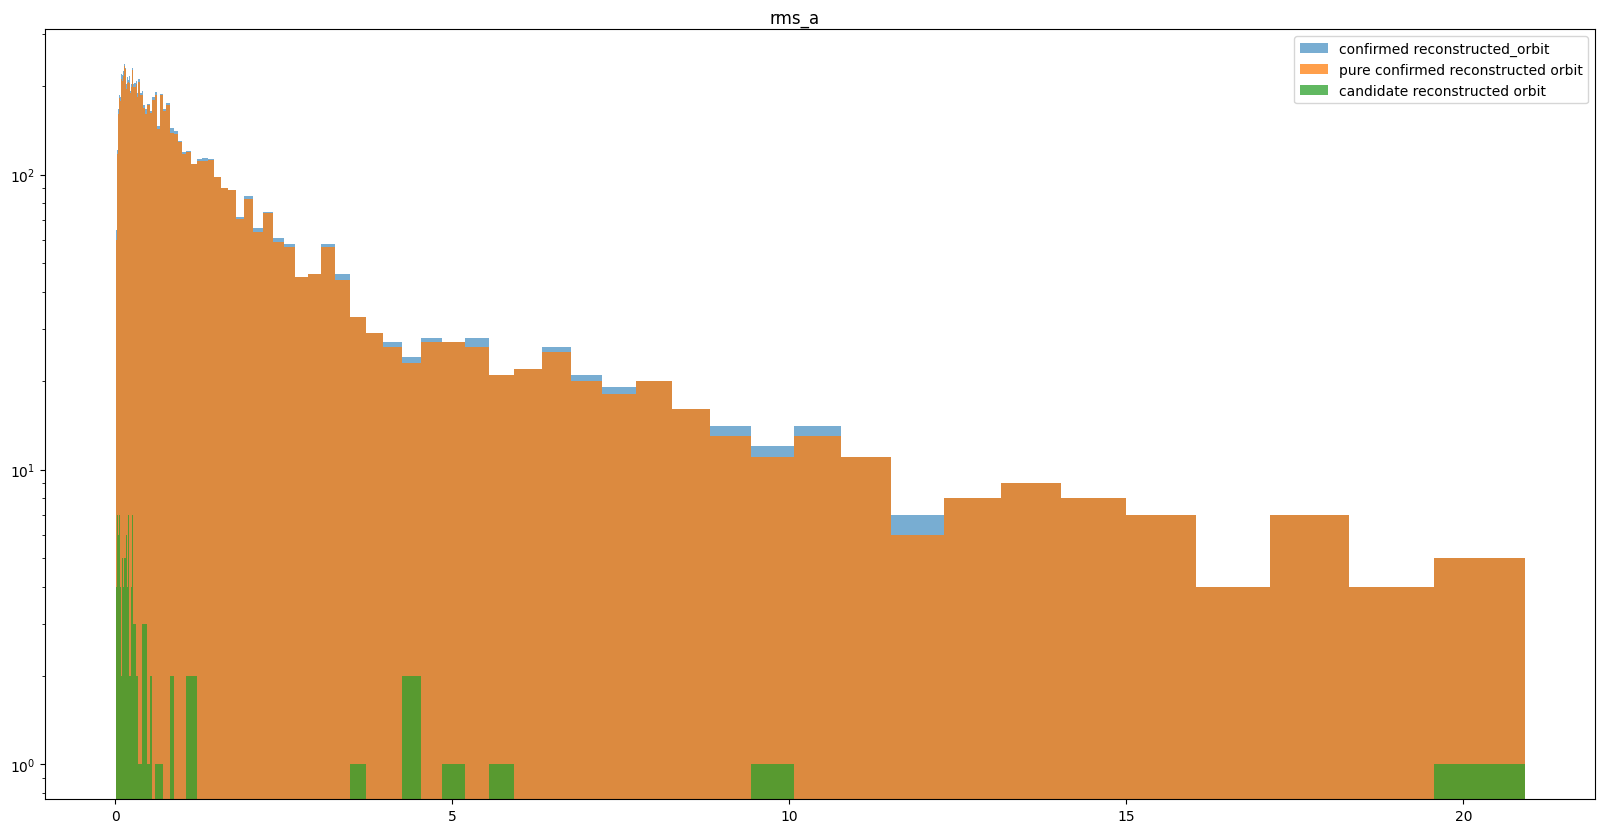

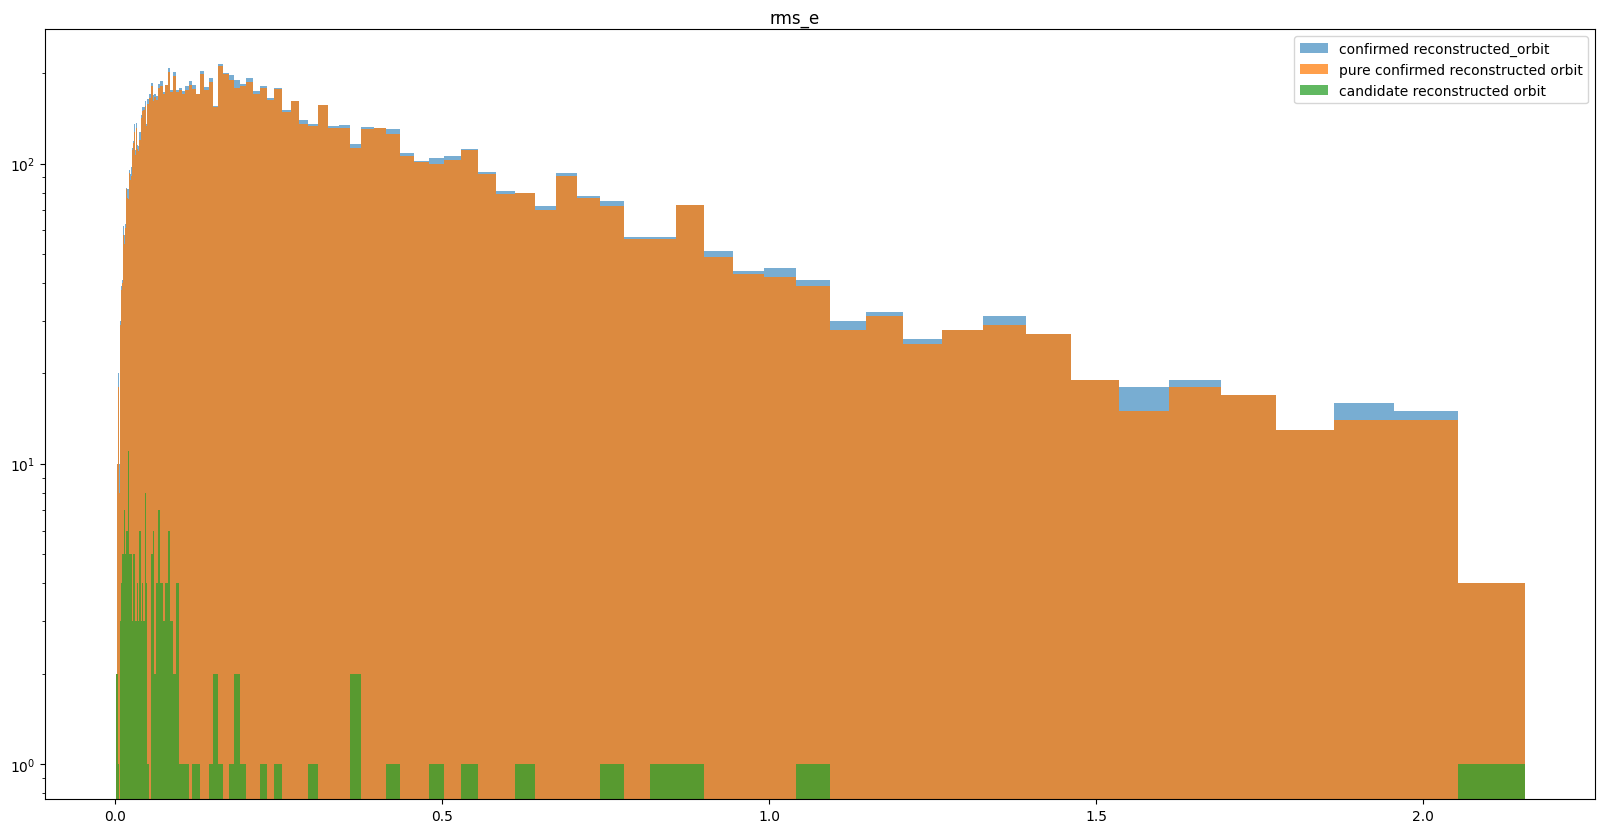

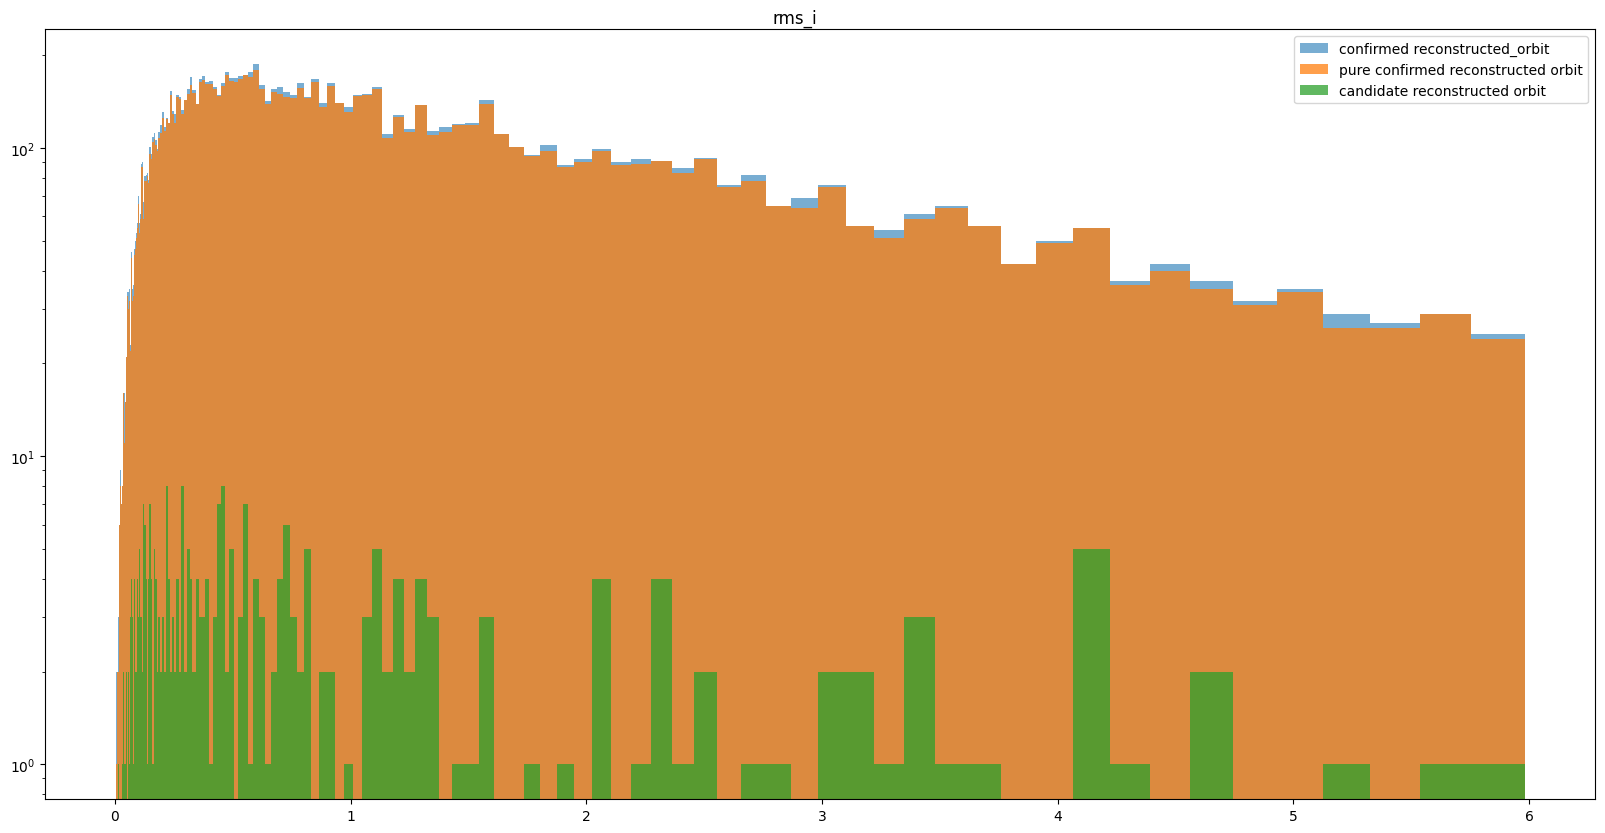

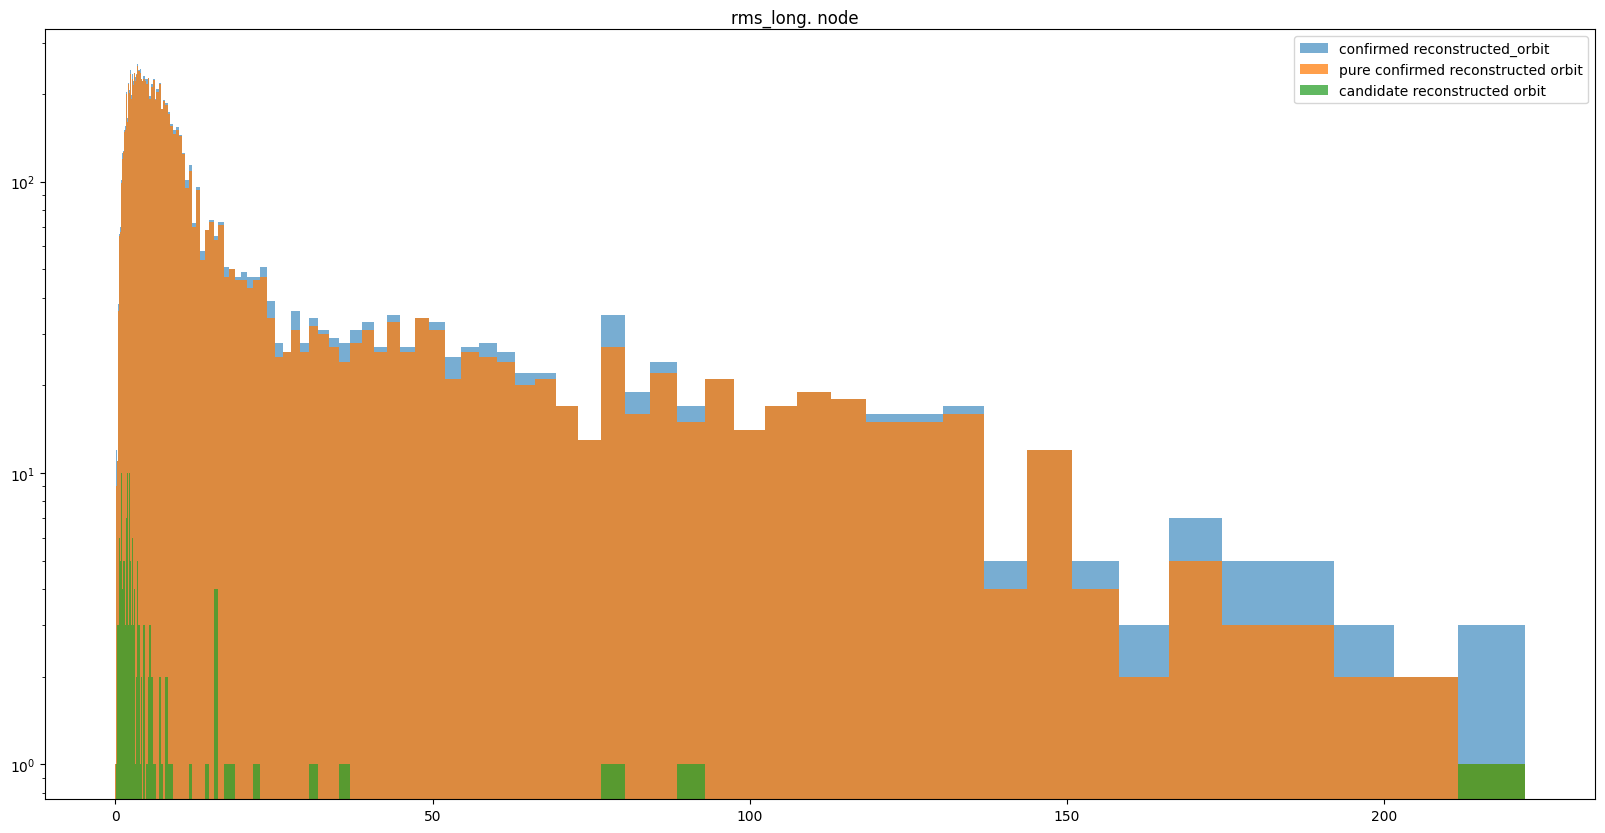

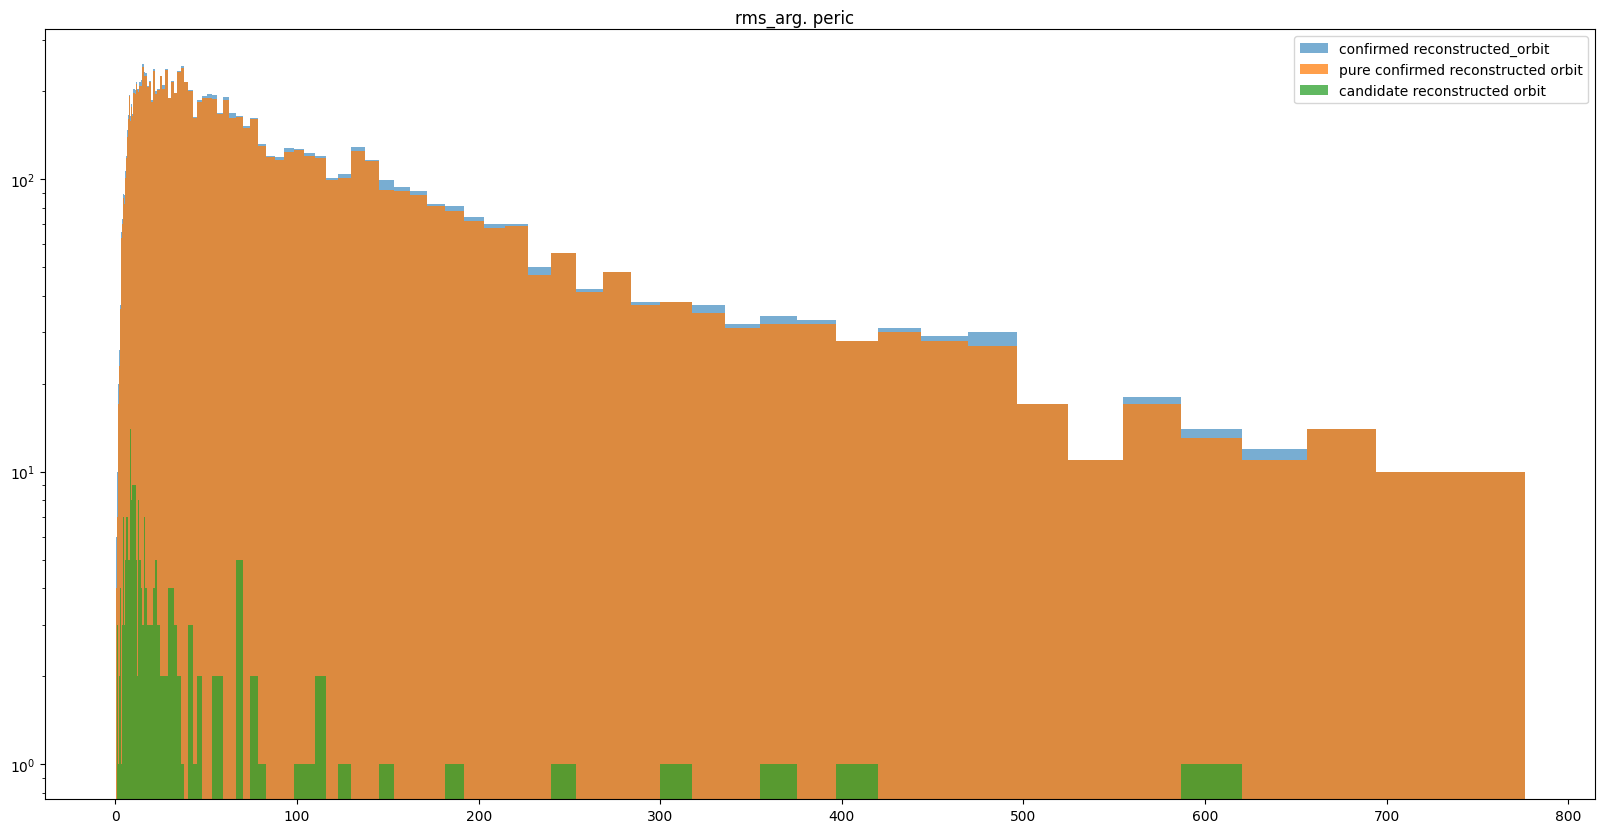

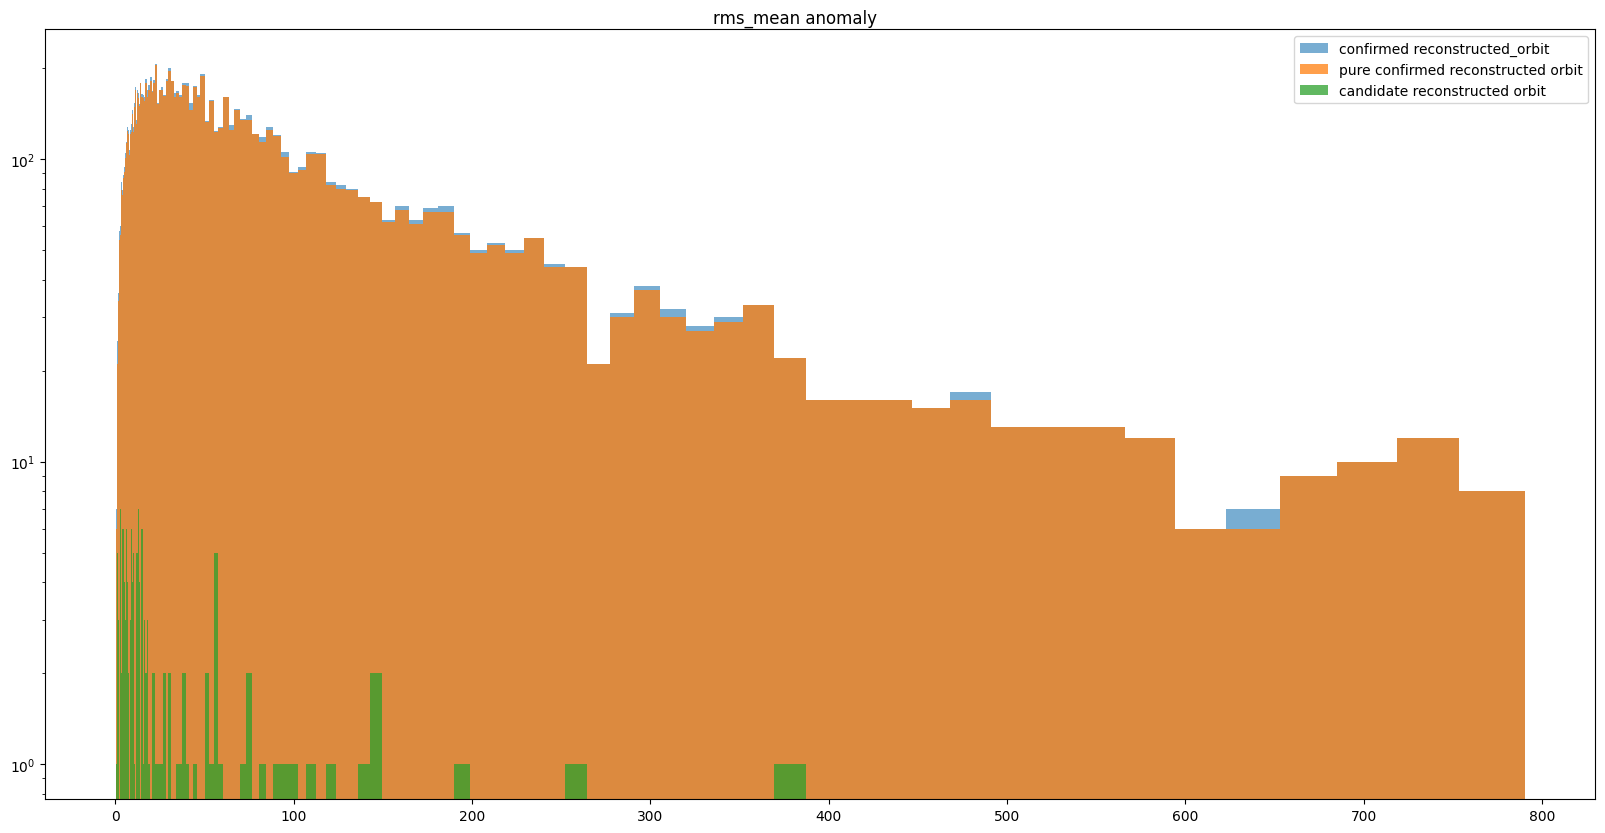

In [39]:
u.compare_confirmed_and_candidates_rms(
    reconstructed_orbit, 
    reconstructed_trajectory, 
    candid_reconstr_orbit[candid_reconstr_orbit["d:rms_a"] != -1.0]
)

#### SkyBot association